# jammer
## 20 - Automate everything in K-band
### Part I. automate

In [1]:
import pandas as pd

In [2]:
#! head -n 30 ../data/IGRINS/2M0136+0933_20161101_H_0030_merged.txt

In [3]:
dat = pd.read_csv('../data/IGRINS/2M0136+0933_20161101_K_0030_merged.txt', names=['wl', 'fl', 'sigma', 'msk'],
                  comment='#', delim_whitespace=True)
dat['sigma']=dat.sigma.astype(np.float)

>The files have four columns each. The first is wavelength in microns. The second is flux, units are ergss-1cm-2A-1. The third and fourth columns I would ignore. The third one should be uncertainty but we aren't really sure we can trust those with the IGRINS data, and the fourth is a flag array that the SpeX data has but the IGRINS data doesn't, so its all zeroes. 

In [4]:
dat.head()

,wl,fl,sigma,msk
0,1.86636,-24976.801,510722.88,0.0
1,1.86637,-1284220.000,3144176.50,0.0
2,1.86638,918119.000,-688720.12,0.0
3,1.86640,-1464900.000,-1080971.40,0.0
4,1.86641,-3046470.000,1668046.50,0.0


## An example Marley model

In [5]:
mar = pd.read_csv('../../Starfish/libraries/raw/marley13/sp_t1300g1780nc_m0.0', 
                  names=['wavelength', 'flux'],
                  skiprows=3, 
                  delim_whitespace=True)

In [6]:
import astropy.units as u
import astropy.constants as C
c_val = C.c.to(u.cm/u.s).value
c_val

29979245800.0

In [7]:
x = mar.wavelength.values*u.micron
x_Hz = x.to(u.Hz, equivalencies=u.spectral())
x_Ang = x.to(u.Angstrom)


y0 = mar.flux.values*u.erg/u.cm**2/u.s/u.Hz
y = y0.to(u.erg/u.cm**2/u.s/u.Angstrom, 
          equivalencies=u.spectral_density(mar.wavelength.values*u.micron))

In [8]:
yl1, yl2 = np.nanpercentile(dat.fl, [10, 90])

(2.0, 2.5)

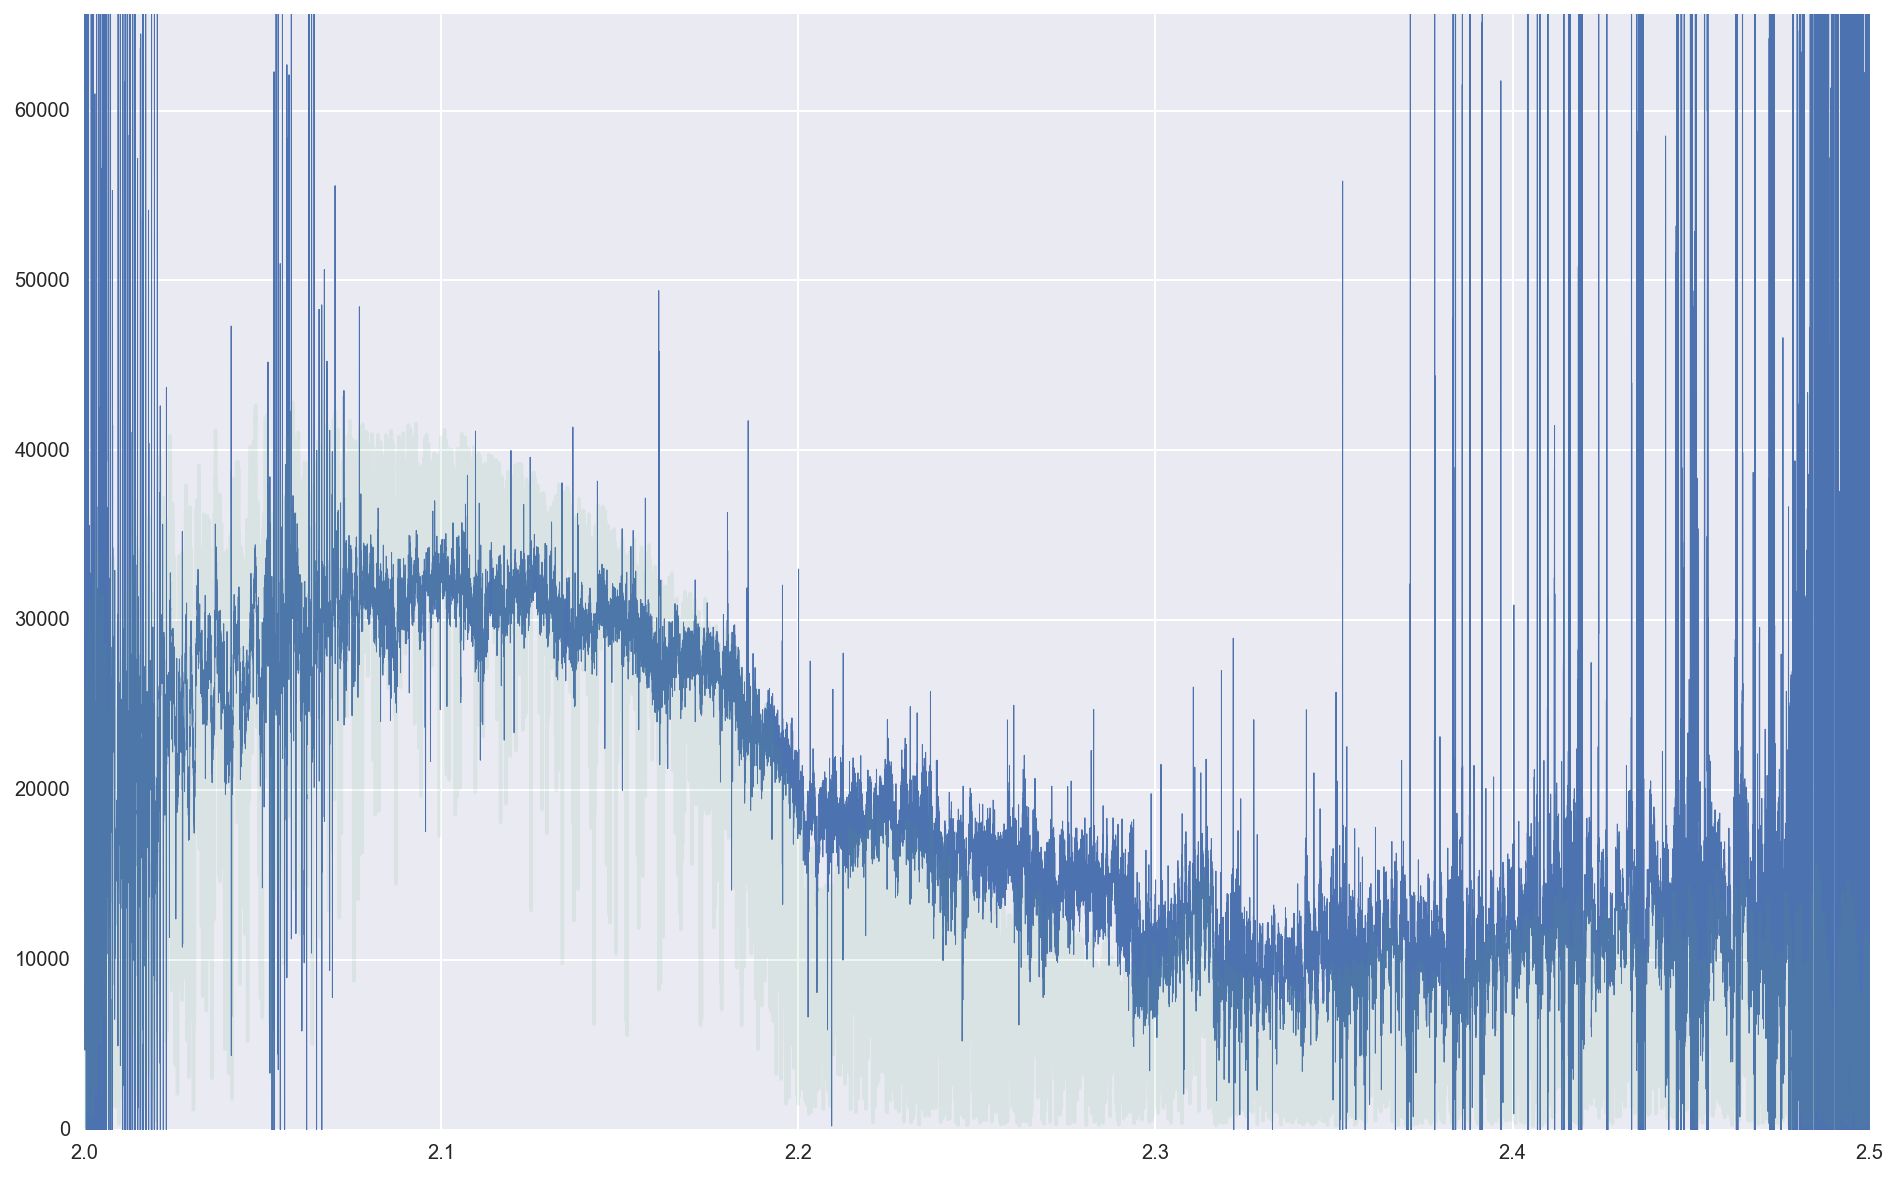

In [9]:
plt.figure(figsize=(16, 10))
plt.plot(dat.wl, dat.fl, lw=0.5)
plt.plot(x, y*6, alpha=0.1)
plt.ylim(0, 2.0*yl2)
plt.xlim(2.0, 2.5)

Let's clean/drop the noise spikes.

In [10]:
from scipy.signal import medfilt

In [11]:
fl_smoothed = medfilt(dat.fl, kernel_size=21)

In [12]:
resid = dat.fl-fl_smoothed

In [13]:
n_pix = len(resid)*0.65

In [14]:
fake_dist = np.random.normal(0, 1000, size=n_pix)

/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:1: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  if __name__ == '__main__':


(-5000, 5000)

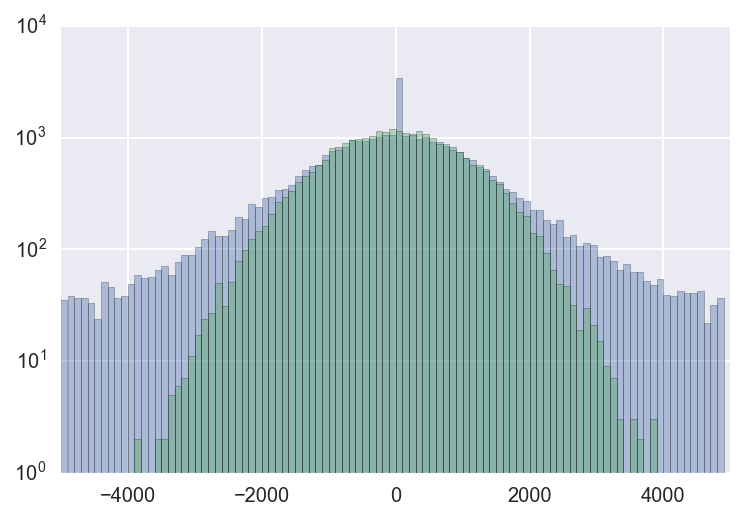

In [15]:
sns.distplot(resid[resid.notnull()].values, bins=np.arange(-5000, 5000, 100), kde=False)
sns.distplot(fake_dist, bins=np.arange(-5000, 5000, 100), kde=False)
#sns.distplot(, bins=np.arange(-100000, 1000000, 100), kde=False)
plt.yscale('log')
plt.xlim(-5000, 5000)

Long tailed distribution indicative of cosmic-ray like structures-- Gaussian distribution expects essentially zero pixels with values greater than 5000.  We do have sigma info, so let's see if the sigmas are also large.

In [16]:
from scipy.stats import multivariate_normal

In [17]:
dat["sigma"] = np.abs(dat["sigma"])

In [18]:
gi = dat.sigma.notnull() & np.isfinite(dat.sigma) & dat.sigma != 0

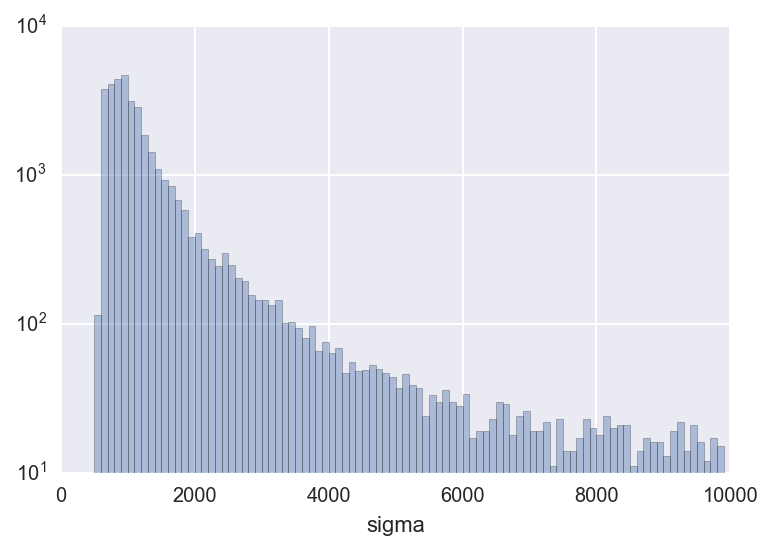

In [19]:
sns.distplot(dat["sigma"][gi], bins=np.arange(0, 10000, 100), kde=False)
plt.xlim(0, 10000)
plt.yscale('log')

Heteroscedastic, naturally.

In [20]:
deviation = resid/dat["sigma"]

In [21]:
gi = deviation.notnull() & np.isfinite(deviation) & deviation!=0

In [22]:
fake_dist2 = np.random.normal(0, 1, size=gi.sum()*0.9)

/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:1: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  if __name__ == '__main__':


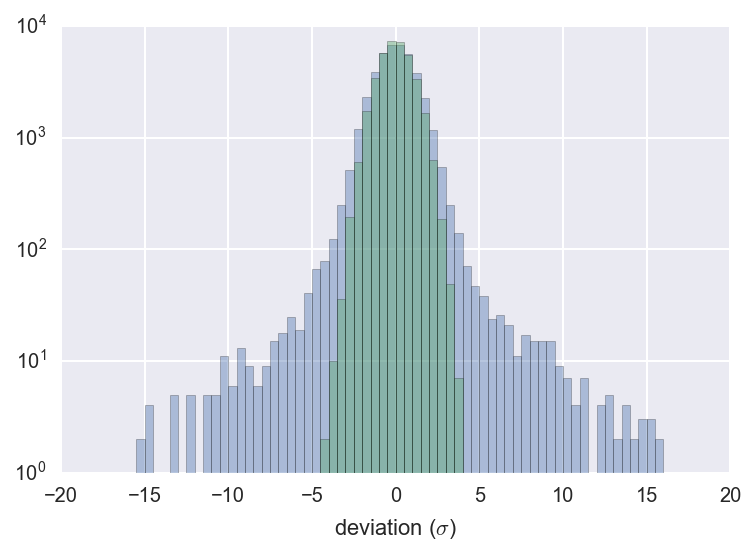

In [23]:
sns.distplot(deviation[gi], bins=np.arange(-100, 100, 0.5), kde=False)
sns.distplot(fake_dist2, bins=np.arange(-100, 100, 0.5), kde=False)
plt.xlim(-20, 20)
plt.yscale('log')
plt.xlabel('deviation ($\sigma$)');

In [24]:
bi = (((np.abs(deviation) > 4.7) & (np.abs(resid) >3700)) | dat.sigma.isnull())

(2.0, 2.5)

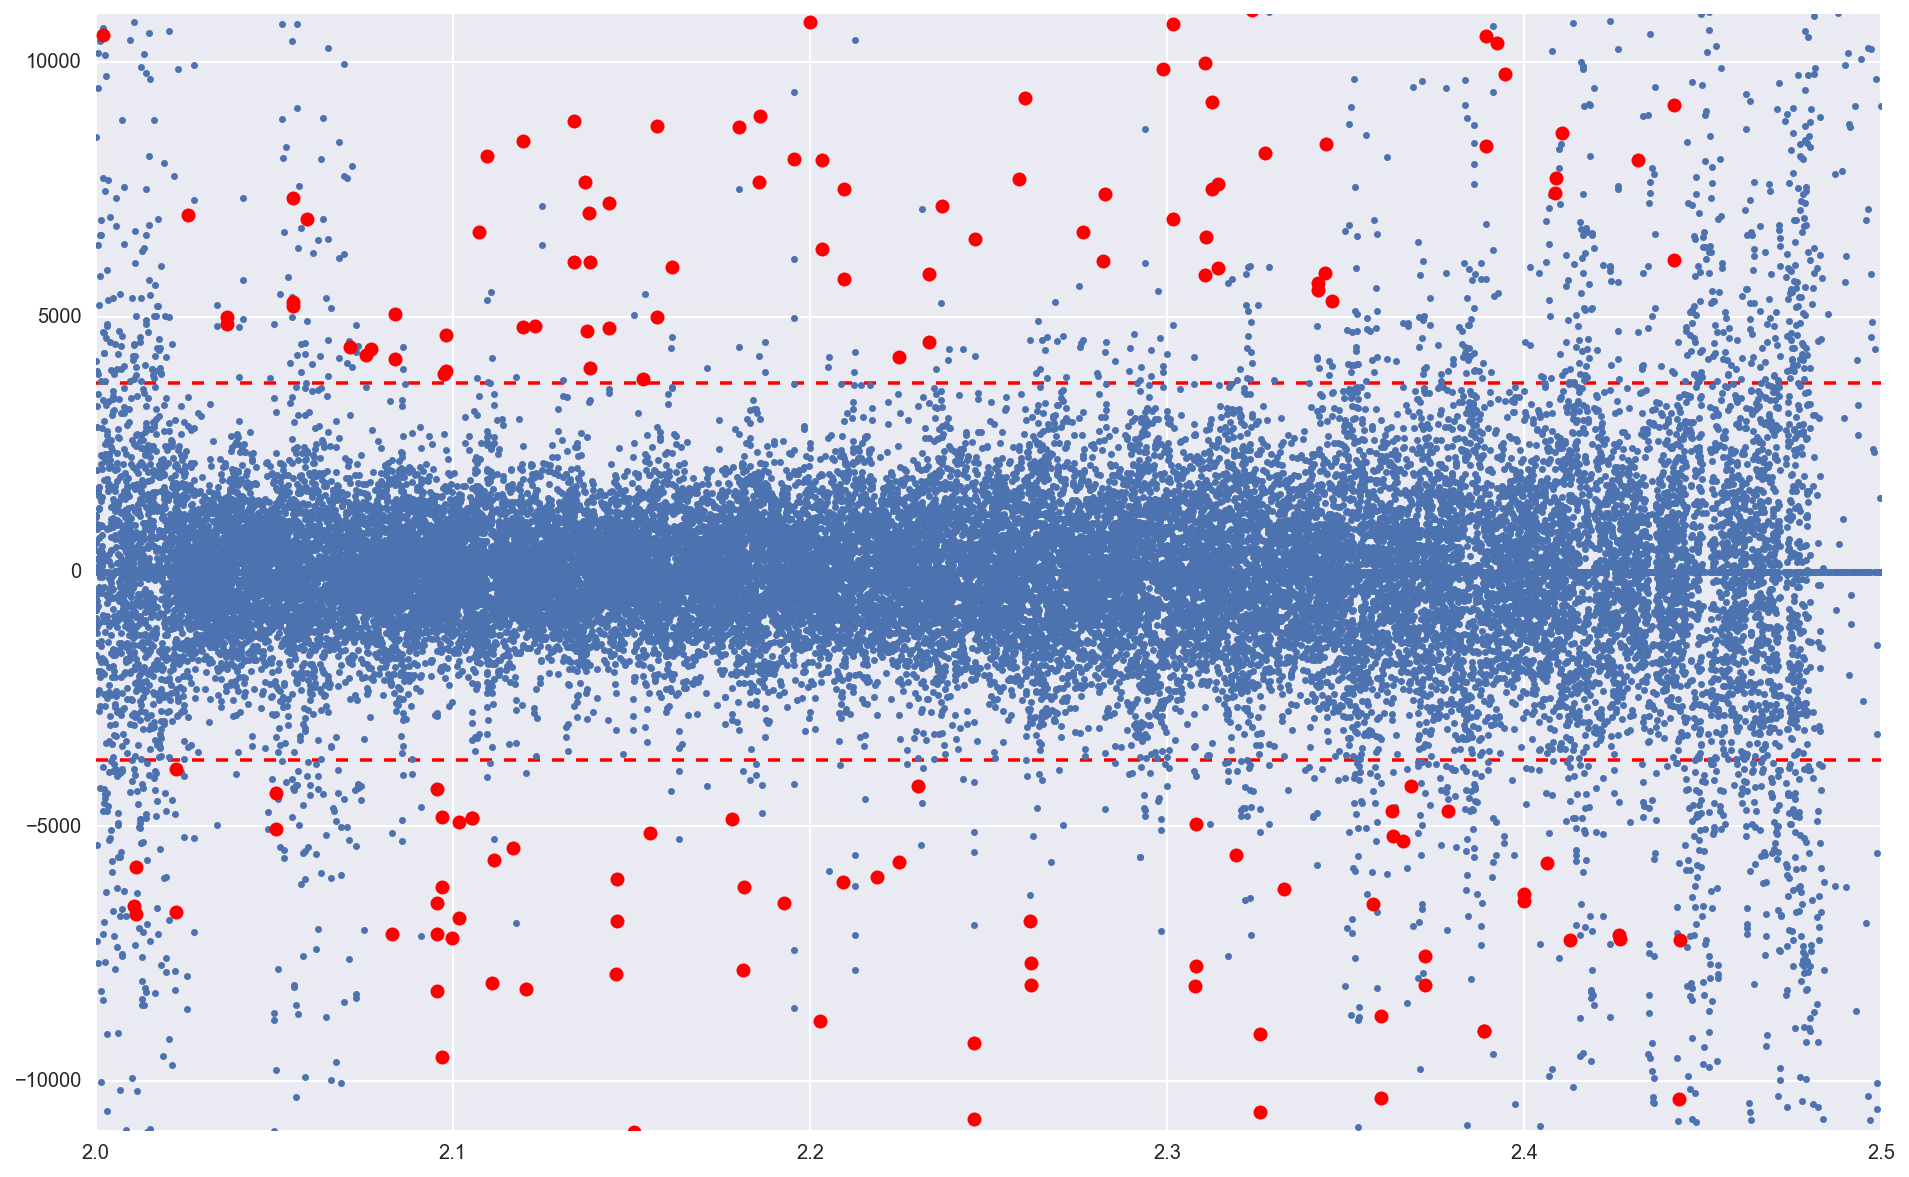

In [25]:
plt.figure(figsize=(16, 10))
plt.plot(dat.wl, resid, '.')
plt.plot(dat.wl[bi], resid[bi], 'ro')
plt.ylim(-yl2/3, yl2/3)
plt.hlines(3700, 2.0, 2.5, colors='r', linestyles='dashed')
plt.hlines(-3700, 2.0, 2.5, colors='r', linestyles='dashed')
plt.xlim(2.0, 2.5)

(2.0, 2.5)

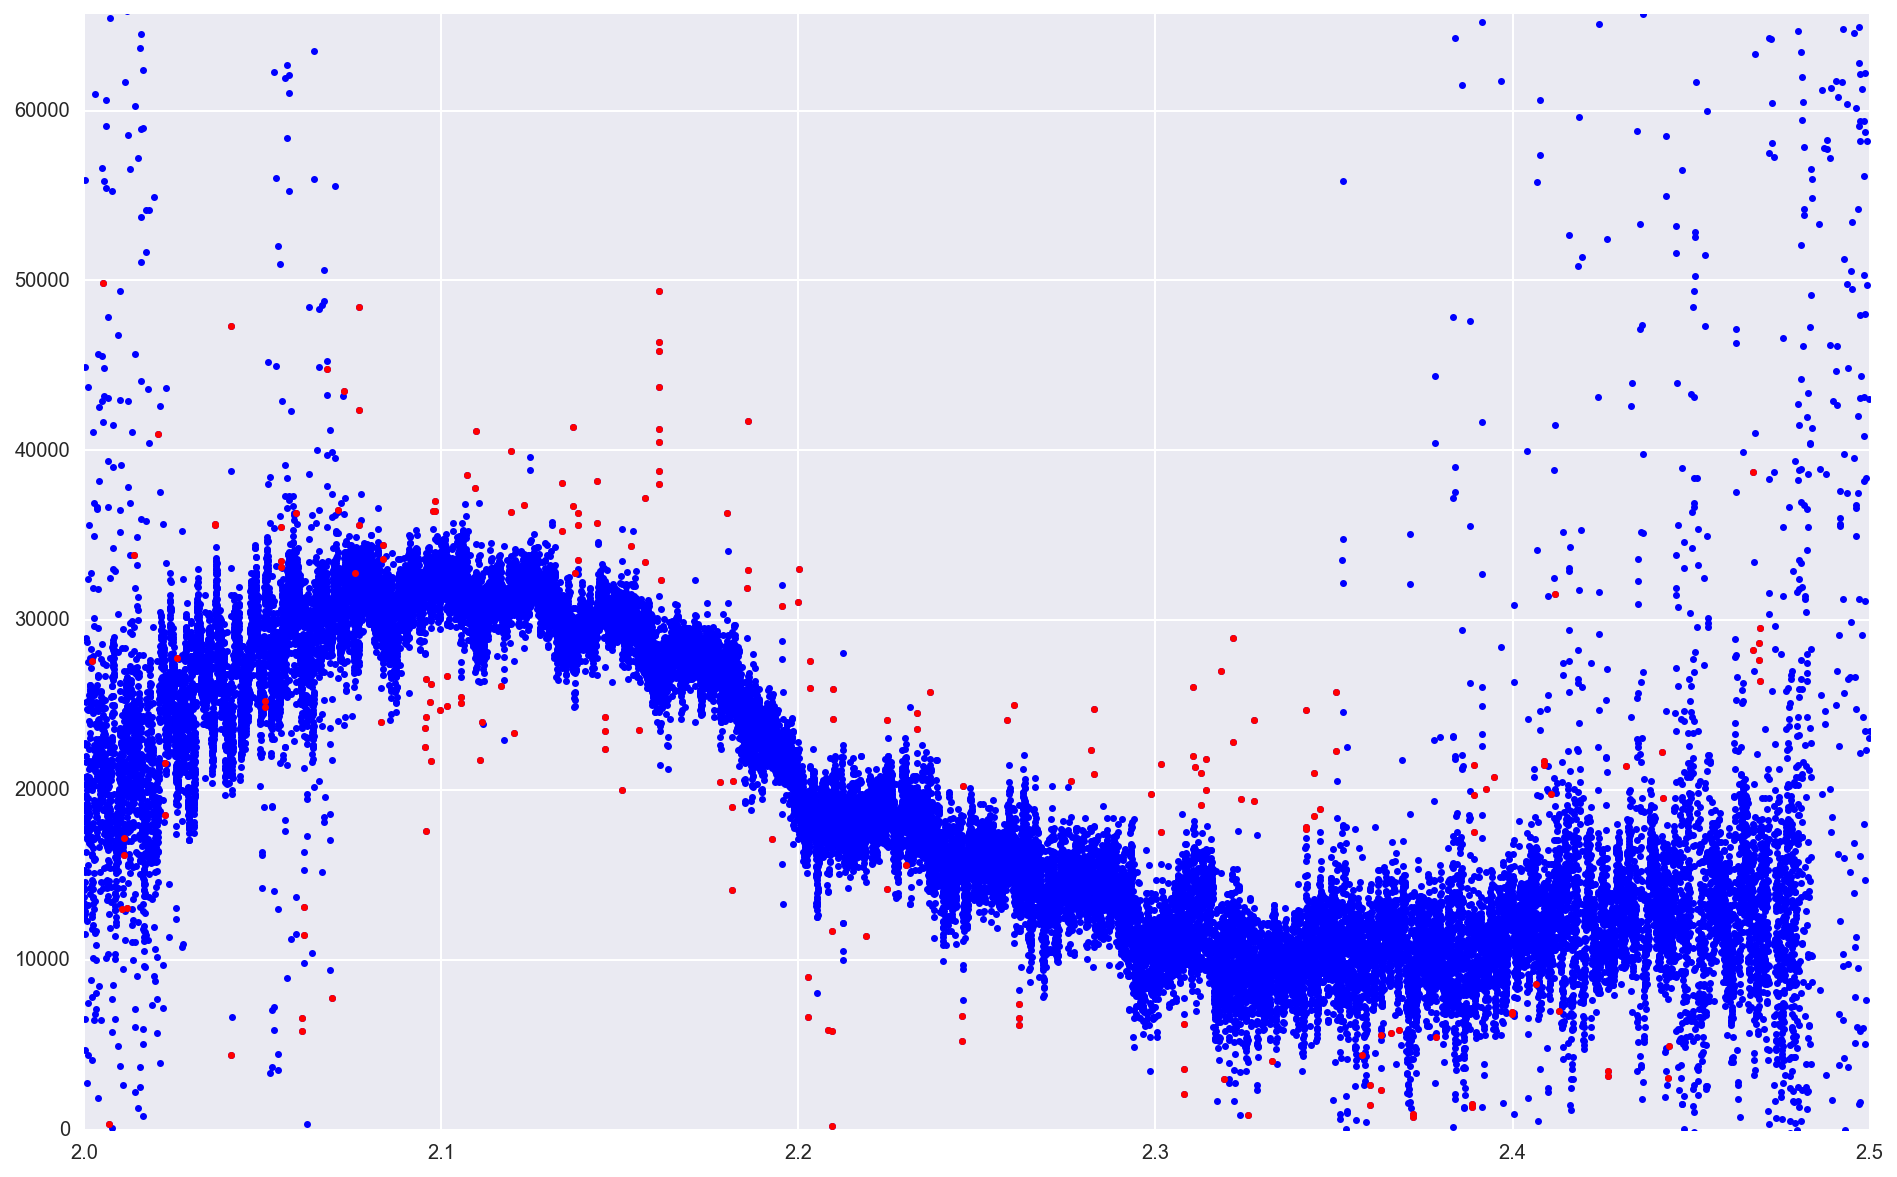

In [26]:
plt.figure(figsize=(16, 10))
plt.plot(dat.wl, dat.fl, 'b.')
plt.plot(dat.wl[bi], dat.fl[bi], 'r.')
plt.ylim(0, 2.0*yl2)
plt.xlim(2.0, 2.5)
#plt.xlim(2.12, 2.16)

We will **drop** these pixels completely.

In [27]:
dat.shape

(44689, 4)

In [28]:
dat.drop(dat.index[bi]).shape

(43945, 4)

In [31]:
dat_cln = dat.drop(dat.index[bi])

(-5, 100)

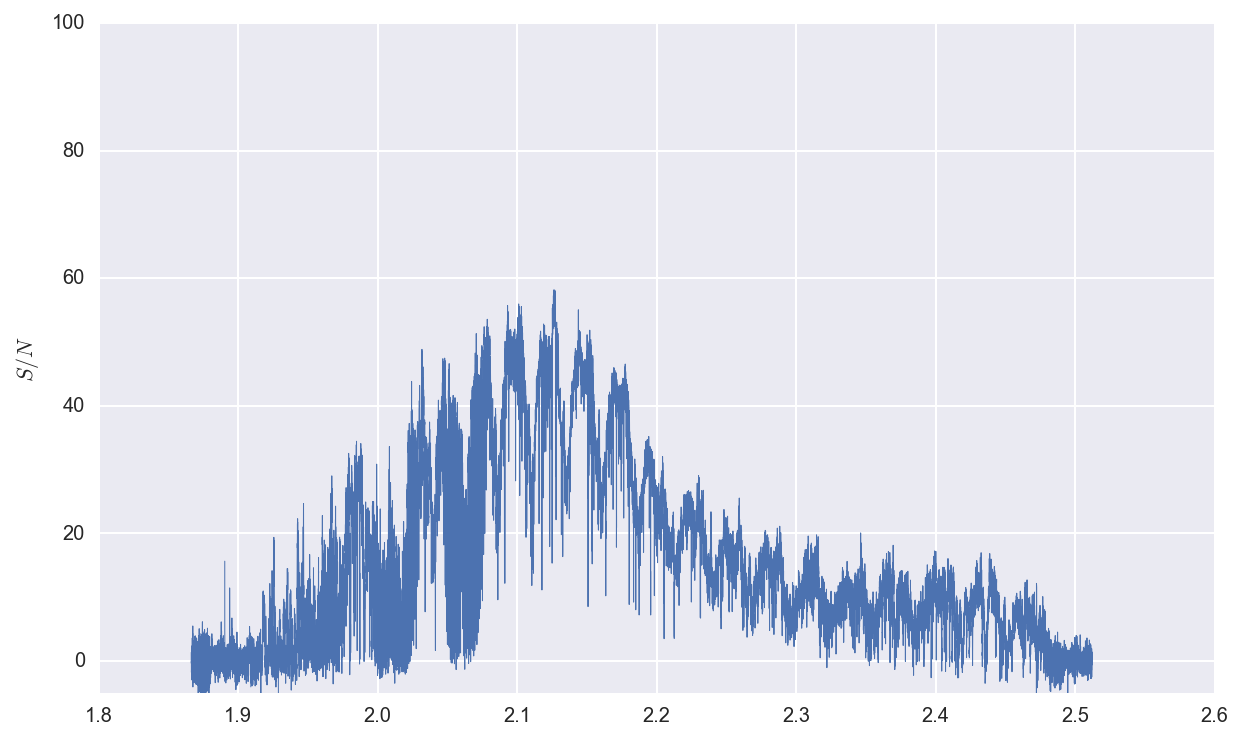

In [32]:
plt.figure(figsize=(10, 6))
#plt.plot(dat.wl, dat.fl/dat.sigma, lw=0.5, alpha=0.5)
plt.plot(dat_cln.wl, dat_cln.fl/dat_cln.sigma, lw=0.5)
plt.ylabel('$S/N$')
plt.ylim(-5, 100)

## Break the spectrum into chunks

How big should the chunks be /  how many chunks?

Let's say approximately 1500 pixels per chunk?  They don't necessarily have to coincide with orders, which will help us simplify things for now.

In [33]:
n_pix, _ = dat_cln.shape

In [34]:
n_pix/1450.0

30.306896551724137

About 30 chunks across the band.

In [35]:
delta_wl = (dat_cln.wl.max()-dat_cln.wl.min())
delta_wl*10000

6456.2020000000039

About 6500 Angstroms of bandwidth

In [36]:
delta_wl/30.0*10000

215.20673333333349

OK, let's pick 200 Angstrom chunks.

In [37]:
dat.wl.min(), dat.wl.max()

(1.8663598999999997, 2.5119801000000002)

Ditch the last partial order for simplicity (it's noisy anyways).

In [38]:
wl_beginnings = np.arange(dat.wl.min()*10000.0, dat.wl.max()*10000.0, 200.0)[:-1]
wl_mid = wl_beginnings + 100.0
wl_ends = np.arange(dat.wl.min()*10000.0+200.0, dat.wl.max()*10000.0, 200.0)

In [39]:
wl_beginnings.shape, wl_ends.shape

((32,), (32,))

In [40]:
ch = 10

### Spot check each spectral "chunk"

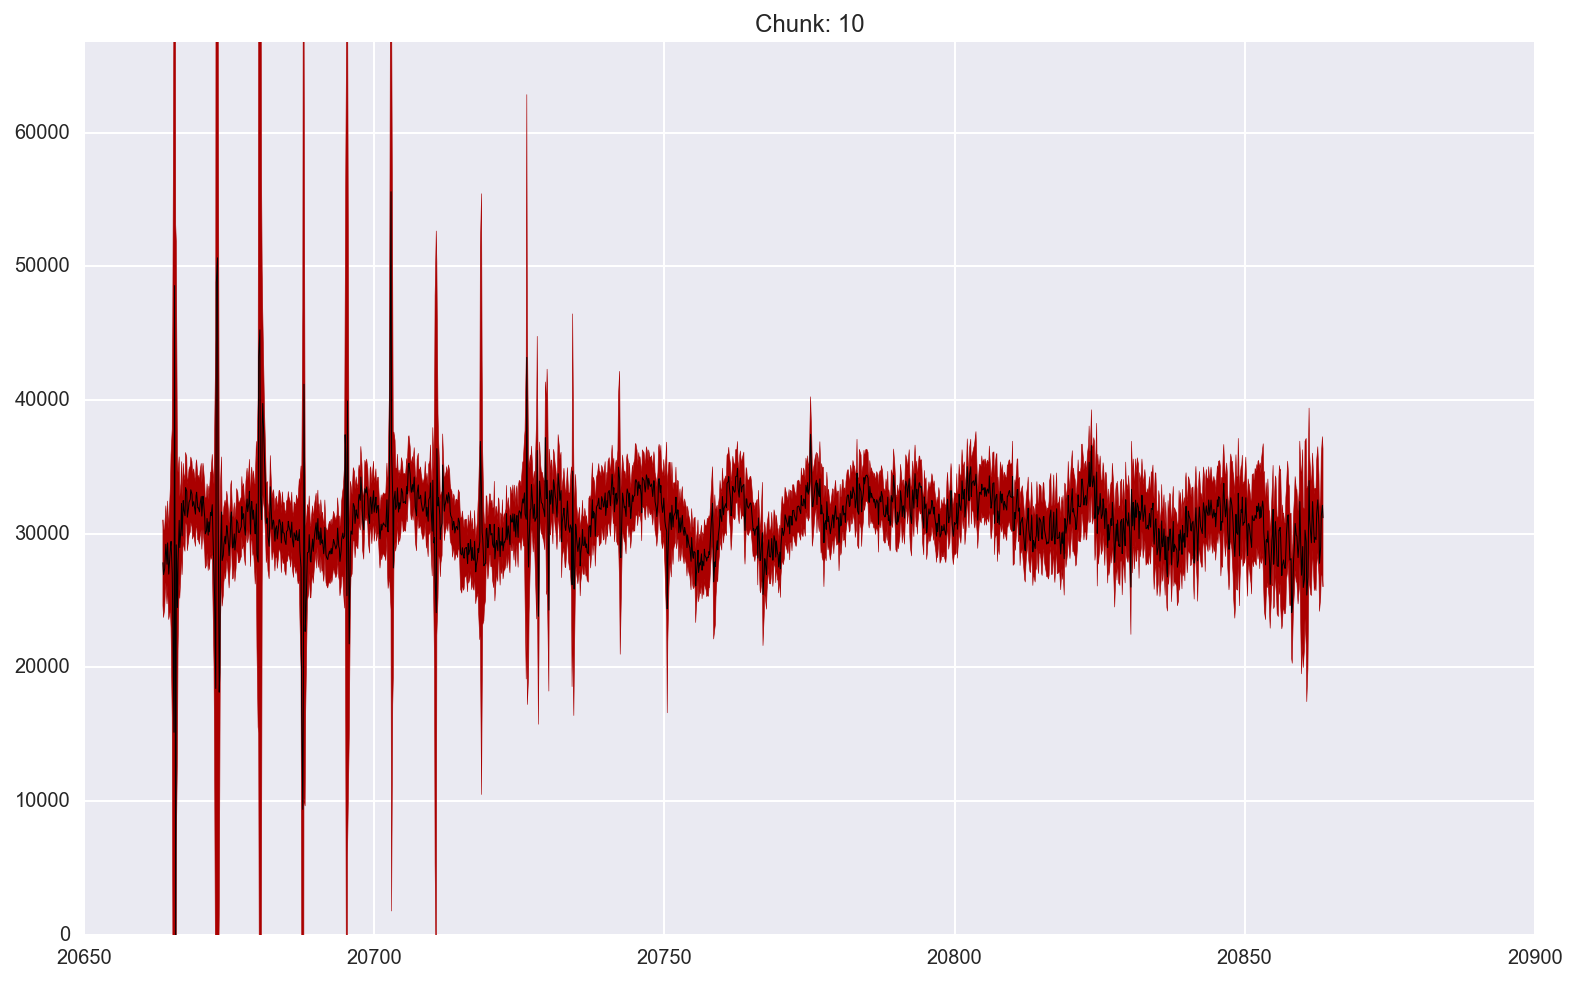

In [41]:
plt.figure(figsize=(13,8))
gi = (dat_cln.wl*10000 > wl_beginnings[ch]) & (dat_cln.wl*10000 < wl_ends[ch])
wl = dat_cln.wl[gi]*10000
fl = dat_cln.fl[gi]
sig = dat_cln.sigma[gi]

plt.plot(wl, fl, 'k-', lw=0.5)
plt.title("Chunk: {}".format(ch))
plt.fill_between(wl, fl-3.0*sig, fl+3.0*sig, color='#AA0000')

plt.ylim(0, 2.0*np.nanpercentile(fl, 90))

ch = ch +1

### Save each spectral chunk to its own HDF5 file

In [42]:
import h5py

In [43]:
! rm ../data/IGRINS/reduced/2M0136+0933_K*

In [44]:
for ch in range(0, 32):
    out_name = '../data/IGRINS/reduced/2M0136+0933_K_ch{:03}.hdf5'.format(ch)

    gi = (dat_cln.wl*10000 > wl_beginnings[ch]) & (dat_cln.wl*10000 < wl_ends[ch])
    wl = dat_cln.wl[gi].values*10000
    fl = dat_cln.fl[gi].values
    sig = dat_cln.sigma[gi].values
    msk = np.zeros(len(wl))

    f_new = h5py.File(out_name, 'w')
    f_new.create_dataset('fls', data=fl)
    f_new.create_dataset('wls', data=wl)
    f_new.create_dataset('sigmas', data=sig)
    f_new.create_dataset('masks', data=msk)
    print("{:.0f}  -  {:.0f}   {}".format(wl[0], wl[-1], out_name))
    f_new.close()

18664  -  18863   ../data/IGRINS/reduced/2M0136+0933_K_ch000.hdf5
18864  -  19063   ../data/IGRINS/reduced/2M0136+0933_K_ch001.hdf5
19064  -  19263   ../data/IGRINS/reduced/2M0136+0933_K_ch002.hdf5
19264  -  19464   ../data/IGRINS/reduced/2M0136+0933_K_ch003.hdf5
19464  -  19664   ../data/IGRINS/reduced/2M0136+0933_K_ch004.hdf5
19664  -  19864   ../data/IGRINS/reduced/2M0136+0933_K_ch005.hdf5
19864  -  20064   ../data/IGRINS/reduced/2M0136+0933_K_ch006.hdf5
20064  -  20263   ../data/IGRINS/reduced/2M0136+0933_K_ch007.hdf5
20264  -  20463   ../data/IGRINS/reduced/2M0136+0933_K_ch008.hdf5
20464  -  20663   ../data/IGRINS/reduced/2M0136+0933_K_ch009.hdf5
20664  -  20864   ../data/IGRINS/reduced/2M0136+0933_K_ch010.hdf5
20864  -  21063   ../data/IGRINS/reduced/2M0136+0933_K_ch011.hdf5
21064  -  21263   ../data/IGRINS/reduced/2M0136+0933_K_ch012.hdf5
21264  -  21463   ../data/IGRINS/reduced/2M0136+0933_K_ch013.hdf5
21464  -  21663   ../data/IGRINS/reduced/2M0136+0933_K_ch014.hdf5
21664  -  

## Auto generate the configuration files and make the paths

# see `$jammer/code/batch*` for the batch code.  Below is a guide:

```python
for ch in range(0, 32):

    dat_name = '../data/IGRINS/reduced/2M0136+0933_K_ch{:03}.hdf5'.format(ch)
    path_out = 'K_ch{:03d}/'.format(ch)
    sf_out = 'K_ch{:03d}/config.yaml'.format(ch)
    
    f = open("K_ch010/config.yaml")
    config = yaml.load(f)
    f.close()
    
    f=h5py.File(dat_name, "r")
    wls = f['wls'][:]
    f.close()
    
    config['data']['files'] = ['$jammer/data/IGRINS/reduced/2M0136+0933_K_ch{:03d}.hdf5'.format(ch)]
    config['grid']['hdf5_path'] = '$WELTER/sf/m{:03d}/libraries/PHX_IGR_2700-4500_m{:03d}.hdf5'.format(m,m)
    lb, ub = int(np.floor(wls[0])), int(np.ceil(wls[-1]))

    config['grid']['wl_range'] = [lb, ub]
    config['PCA']['path'] = '$jammer/sf/2M0136/K_ch{:03d}/libraries/Marley_IGRINS_Teff1000-1500.hdf5'.format(ch)
    config['Theta_priors'] = '$jammer/sf/2M0136/K_ch{:03d}/output/marley_grid/run01/user_prior.py'.format(ch)
    
    os.makedirs(path_out, exist_ok=True)
    with open(sf_out, mode='w') as outfile:
        outfile.write(yaml.dump(config))
        print('wrote to {}'.format(path_out))

#for m in ms:
#    os.chdir("m{:03d}".format(m))
#    os.system('mkdir libraries &')
#    os.system('grid.py --create > grid.out &')
#    os.chdir("..")
```

The end! :)